# **W1D2: Ocean-Atmosphere Reanalysis**

# **Tutorial 3: Atmospheric wind driven circulation**

**Week 1, Day 2, Ocean-Atmosphere Reanalysis**

__Content creators:__ Momme Hell

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Ohad Zivan

**Content editors:** Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

The ocean is influenced by various factors, including solar radiation, winds, and various sources of fresh water such as precipitation, rivers, and melting/freezing ice. This tutorial focuses on examining the global atmospheric wind patterns and how they drive the large-scale ocean currents, known as the "*wind-driven circulation*". The wind-driven circulation plays a crucial role in coastal communities and climates, affecting ocean temperatures, upwelling systems along coastlines, and weather patterns on multiple timescales.

By the end of this tutorial, you will be able to:

- Understand the seasonal variations in surface winds.
- Calculate seasonal climatologies and create global maps.
- Compare statistics derived from these climatologies.

In this tutorial, we will once again utilize the ERA5 dataset. Initially, we will work with example data consisting of 1-hour snapshots each day. Subsequently, we will utilize monthly means over a 30-year period.

In [17]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# Setup

In [18]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
#IFrame(src=f"path-to-video", width=854, height=480)

In [19]:
from intake import open_catalog
import matplotlib.pyplot as plt
import matplotlib
import os
import pooch
import boto3
import botocore
import numpy as np
import xarray as xr
import warnings
import datetime
from cartopy import crs as ccrs, feature as cfeature
#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

In [20]:
# @title plot helping function

def set_projection_figure(projection = ccrs.PlateCarree(), figsize =(5, 4.5) ):
    # source:https://foundations.projectpythia.org/core/cartopy/cartopy.html

    projLccNY =  projection #ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig = plt.figure(figsize=figsize)
    ax = plt.subplot(1, 1, 1, projection=projLccNY)

    format_axes(ax)
    #ax.add_feature(cfeature.STATES)
    #ax.add_feature(cfeature.RIVERS)
    return fig, ax

def format_axes(ax):
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='None', alpha=0.3 )
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='black', alpha=0.5, linestyle='--')
    gl.xlocator = matplotlib.ticker.MaxNLocator(7)
    gl.ylocator = matplotlib.ticker.MaxNLocator(5)
    gl.xlabels_top  = False
    gl.ylabels_left = False
    #gl.xlines = False

# helping functions:
def geographic_lon_to_360(lon):
    return 360 + lon

def inverted_geographic_lon_to_360(lon):
    return lon - 180

def cbar_label(DD):
    return DD.attrs['long_name'] + ' [' + DD.attrs['units']+ ']'

In [21]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")


def font_for_print():

    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 11
    legend_properties = {'weight':'bold'}

    plt.rc('font', size=SMALL_SIZE, serif='Helvetica Neue', weight='normal')          # controls default text sizes
    #plt.rc('font', size=SMALL_SIZE, serif='DejaVu Sans', weight='light')
    plt.rc('text', usetex='false')
    plt.rc('axes', titlesize=MEDIUM_SIZE, labelweight='normal')     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE, labelweight='normal') #, family='bold')    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE, frameon=False)    # legend fontsize
    plt.rc('figure', titlesize=MEDIUM_SIZE, titleweight='bold', autolayout=True) #, family='bold')  # fontsize of the figure title

    plt.rc('axes', labelsize= SMALL_SIZE, labelweight='normal')

font_for_print()

Now we load data from [Pangeo catalog](https://pangeo.io/catalog.html) that we stored on OSF

In [22]:
url_era5 = "https://osf.io/mfztd/download" # contains only one file: 'ERA5_surface_winds_2020-2021_dd_short.nc'
ERA5=xr.open_dataset(pooch.retrieve(url_era5, known_hash=None))
ERA5

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 31)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-01-31
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-07 00:23:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [23]:
print('The time range is:')
print( ERA5.time[0].data.astype('M8[h]') , 'to', ERA5.time[-1].data.astype('M8[h]') )

The time range is:
2020-01-01T00 to 2020-01-31T00


# Section 1: Surface winds driven by the general circulation of the atmosphere.


## Section 1.1: Plotting global surface winds

Let's take an initial glimpse at the data by examining a single day's global surface winds. Surface winds are represented as vectors, consisting of a zonal component denoted as 'u10' and a meridional component denoted as 'v10'. The magnitude of this vector represents the wind speed.

The wind speed is defined as:
$$|u| = u_{\text{speed}} = \sqrt{u^2 + v^2}$$

Now, let's visualize the zonal wind component $u$, the meridional wind component $v$, and the wind speed $u_{\text{speed}}$ for a single time step. Here is the plot of the zonal wind component:


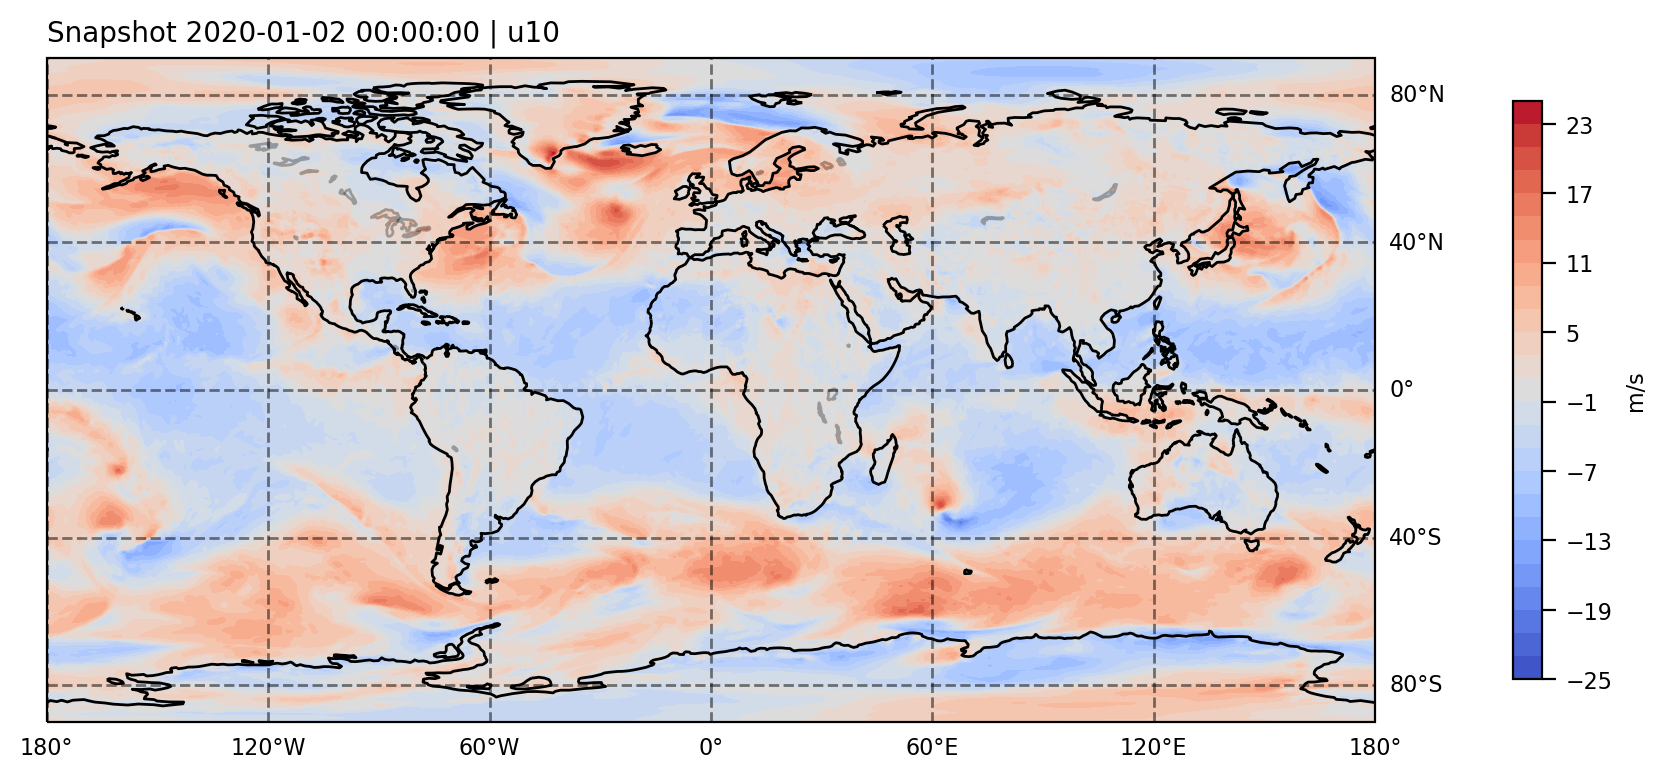

In [24]:
# Pick a day in January 2020. Just make sure you make the same format.
date_sel = datetime.datetime(2020,1,2,0) # select a desired date and hours (midnight is zero)

ERA5_snapshot= ERA5.sel(time=date_sel)

# we define contours levels that will be used in all plots the compare them better
colorlevels = np.arange(-25, 27, 2)

var = 'u10' # choose the variable we want to plot
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) ) # define projection
ax.set_title('Snapshot '+str(date_sel) +' | '+ var , loc ='left') # set title name and location
dataplot = ax.contourf(ERA5_snapshot.longitude, ERA5_snapshot.latitude,
                       ERA5_snapshot[var], levels = colorlevels, transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm
                      ) # plot contours 
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08) # add colorbar

### *Exercise*
Can you make plots for $v_{10}$ and $u_{speed}$ as well? (A reminder - we calculate $u_{speed}$ in tutorial 2)

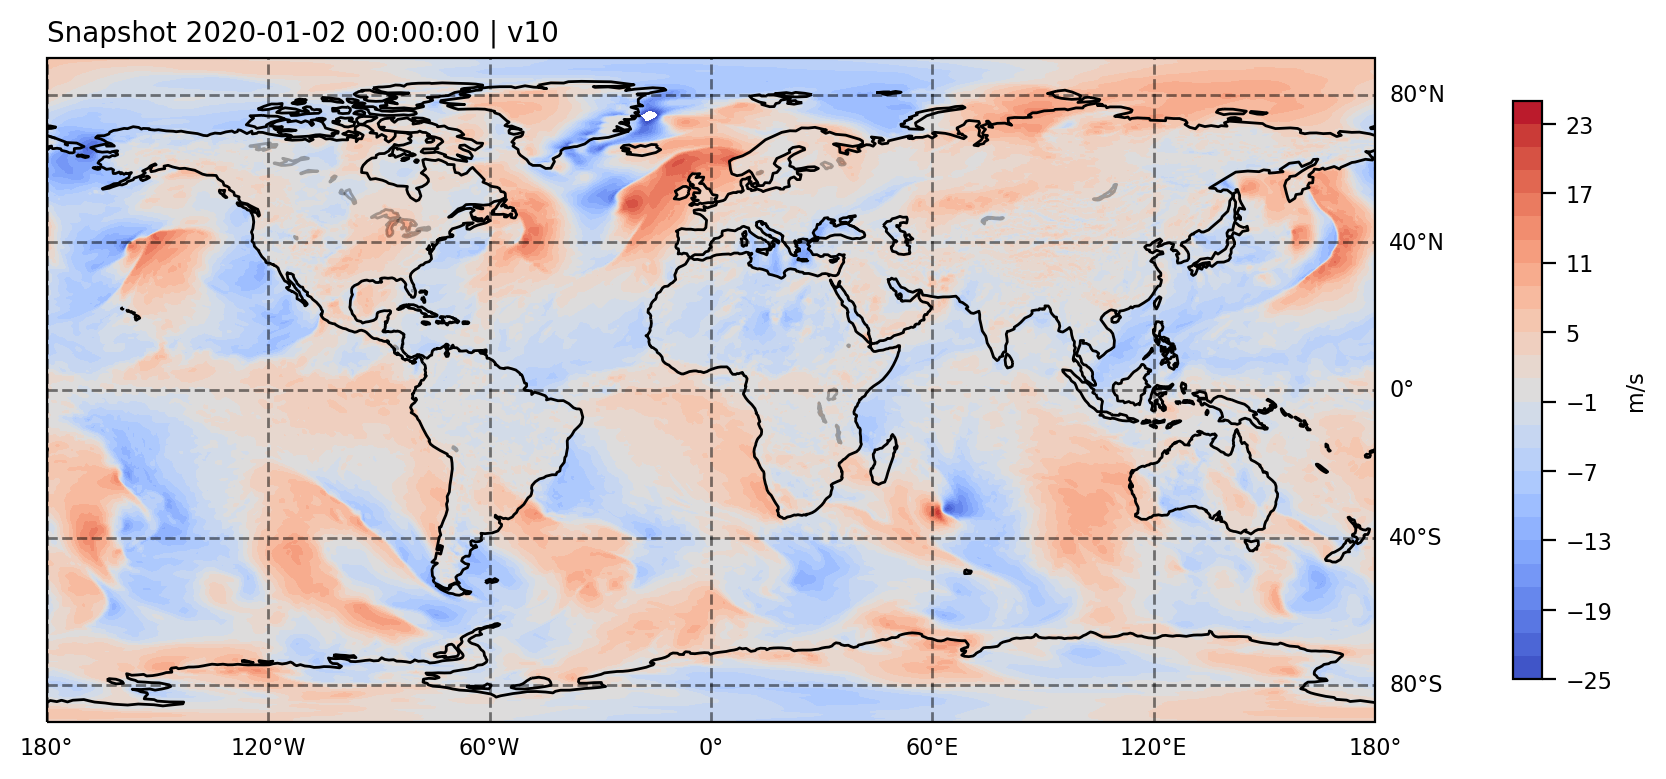

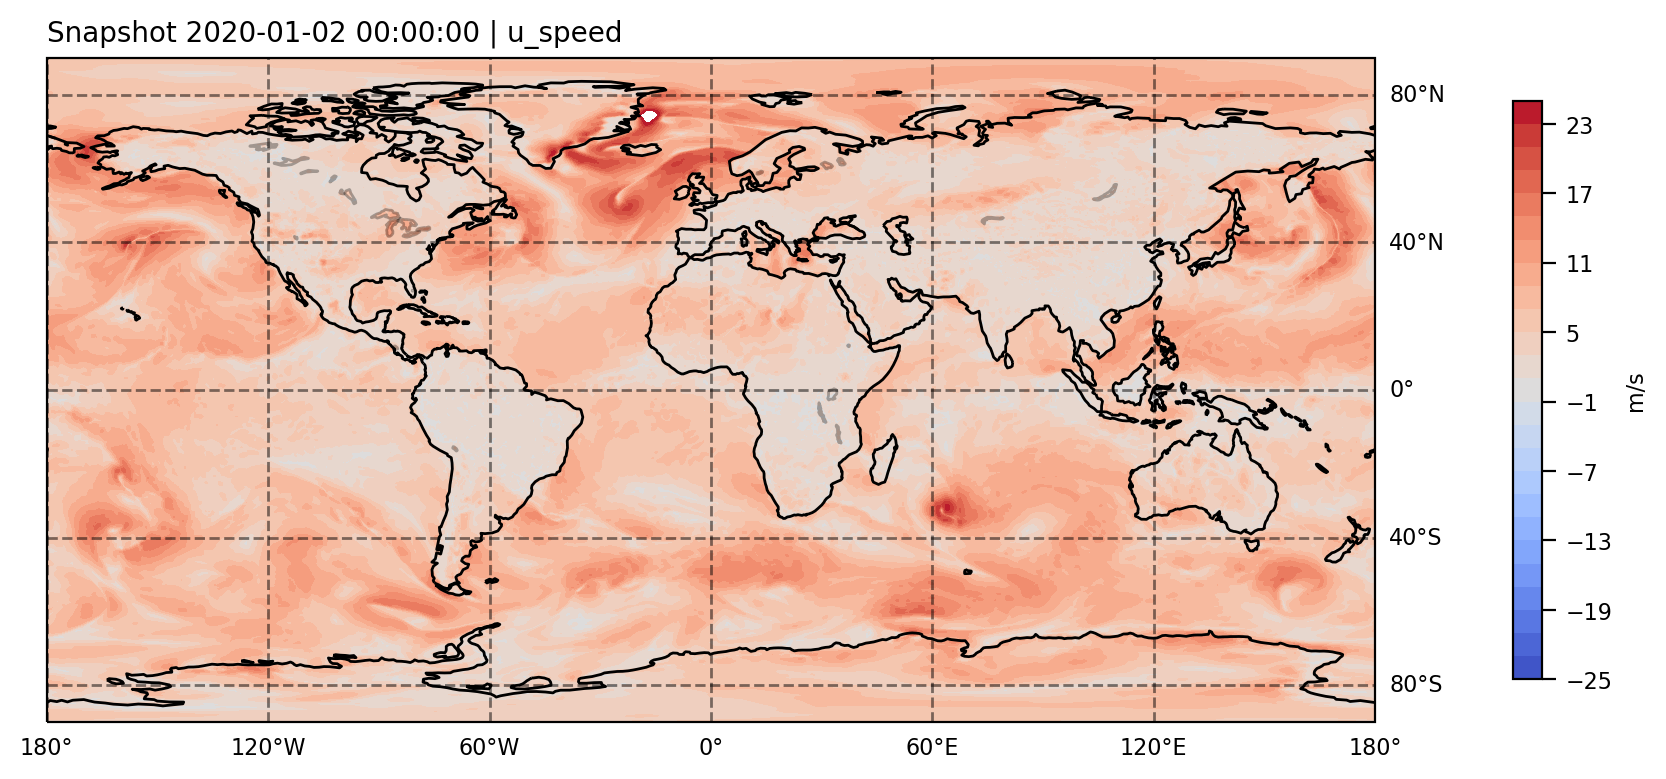

In [25]:
# to remove solution

# plotting v components
var = 'v10'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Snapshot '+str(date_sel) +' | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_snapshot.longitude, ERA5_snapshot.latitude, ERA5_snapshot[var], levels = colorlevels, transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()

# computing u_speed
ERA5_snapshot['u_speed'] = np.sqrt(ERA5_snapshot['u10']**2 + ERA5_snapshot['v10']**2) # the same calculation as in tutorial 2

# plotting u_speed components
var = 'u_speed'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Snapshot '+str(date_sel) +' | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_snapshot.longitude, ERA5_snapshot.latitude, ERA5_snapshot[var], levels = colorlevels, transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()

### *Discussion Questions:*
- What do you observe for the zonal wind component? Where do you see the strongest winds and the most variability?
- How does that compare to the meridional winds?

In [26]:
# to_remove explanation

print (""" 
1. The strongest zonal winds are usually found in the mid-latitudes (around 30-60 degrees latitude) in both hemispheres.
2. Meridional winds are typically weaker and less variable than zonal winds. This is due to the general circulation of the atmosphere, which primarily moves air in the east-west direction rather than north-south. 

""")


 
1. The strongest zonal winds are usually found in the mid-latitudes (around 30-60 degrees latitude) in both hemispheres.
2. Meridional winds are typically weaker and less variable than zonal winds. This is due to the general circulation of the atmosphere, which primarily moves air in the east-west direction rather than north-south. 




## Section 1.2: Extra-tropical Storms

In the wind speed figure, you can notice areas of strong winds over the Southern Ocean, North Pacific, and North Atlantic. These powerful winds are caused by weather systems known as extratropical storms or mid-latitude cyclones. These storms occur in the middle latitudes, between 30 and 60 degrees north or south of the equator. During winter, they are particularly strong over the Southern Ocean and the oceans in the Northern Hemisphere.

Extratropical storms form when warm and cold air masses interact. They have a low-pressure center and produce winds that circulate counterclockwise in the Northern Hemisphere and clockwise in the Southern Hemisphere. These storms can be intense, bringing strong winds, heavy rain, snow, and sleet. They often lead to problems like flooding, power outages, and disruptions in transportation.

The strength of these storms depends on factors such as the temperature difference between air masses, the speed of the jet stream, and the amount of moisture in the air. If you want to learn more about extratropical storms, you can refer to basic meteorology and atmospheric dynamics resources, or you can explore online sources such as the following:

- Wikipedia: [Extratropical Cyclone](https://en.wikipedia.org/wiki/Extratropical_cyclone)
- Pressbooks: [Chapter 13 - Extratropical Cyclones](http://pressbooks-dev.oer.hawaii.edu/atmo/chapter/chapter-13-extratropical-cyclones/)

Although an individual storm may last only a few days and doesn't create significant ocean currents, the continuous winds and the occurrence of multiple storms over a year can influence the development of ocean currents. These currents are a response to the persistent wind patterns. To understand the longer-term impacts of these storms, let's examine more data.

# Section 2: Annual climatology of wind speed:

Now, let's utilize monthly mean data to examine long-term changes in the wind field. With the help of Xarray, you can derive monthly means from higher-resolution data using the `xr.resample('1M').mean('time')` function.

For your convenience, we have already performed this step, and you can load the data using the following instructions:

- The variable 'si10' represents the wind speed in this dataset.
- To calculate the long-term mean, we have selected 30 years of data ranging from 1980 to 2010.

In [27]:
url_era5_mm = "https://osf.io/3q4vs/download" # contains only one file: 'ERA5_surface_winds_mm.nc'
ERA5_mm=xr.open_dataset(pooch.retrieve(url_era5_mm,
                                       known_hash=None)).sel(time=slice('1980', '2010')) # select the timeslice during loading
# note this doesn't load less, but it loads the full file. the assignment to a variable is less. 
ERA5_mm

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 312)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2005-12-01
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    si10       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-06 23:25:45 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### *Note*:
Monthly mean ERA5 data is also avaiable through the Copernicus Portal:

- [ERA5 Monthly mean on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview)
- [ERA5 Monthly mean on pressure levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means?tab=overview)

Now we can start with the climatology of zonal wind

In [28]:
ERA5_ANN = ERA5_mm.mean('time') 

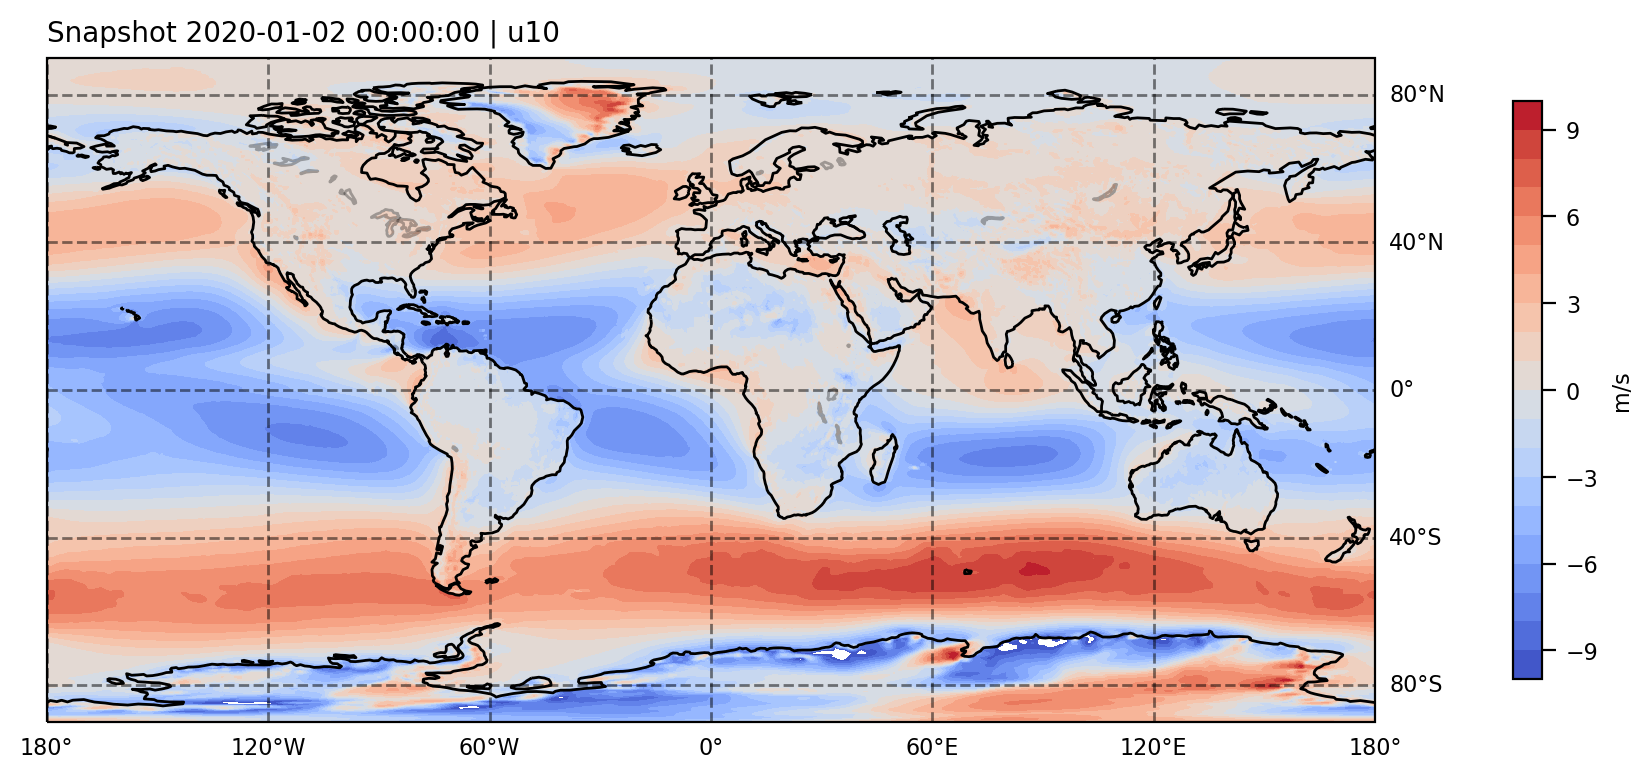

In [29]:
# adjust colorlevels to weaker amplitudes
colorlevels_clim = np.arange(-10, 11, 1)

var = 'u10' # select our variable
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) ) # same plot function as Part I
ax.set_title('Snapshot '+str(date_sel) +' | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_ANN.longitude, ERA5_ANN.latitude, ERA5_ANN[var],
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)

In the wind speed figure, we observe two distinct wind bands between 35 to 65 degrees north or south of the equator. These bands are known as the *westerlies*, found in the mid-latitudes. Additionally, we note that winds predominantly blow from the east in the tropics, referred to as the *easterlies* (less than 30° N/S).

These two wind patterns, the mid-latitude westerlies and the tropical easterlies, are linked through a large-scale circulation of the atmosphere. Often depicted as a three-cell structure, this circulation can be viewed [here](https://commons.wikimedia.org/wiki/File:Earth_Global_Circulation_-_en.svg):

![Earth Global Circulation - en.svg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Earth_Global_Circulation_-_en.svg/740px-Earth_Global_Circulation_-_en.svg.png?20190829153037).

This large-scale circulation significantly influences the climate we experience at different latitudes.

The schematic of circulation cells also reveals a meridional (north-south) component of the surface winds. However, we have only plotted the zonal wind climatology so far. Let's create a plot for the meridional wind climatology and explore its features:



### *Exercise*:
- Among the three atmospheric "cells" depicted in the figure (the Hadley Cell, Ferrel Cell, and Polar Cell), which ones correspond to the zonal wind bands that we visualized in our plot above? Write your code here.

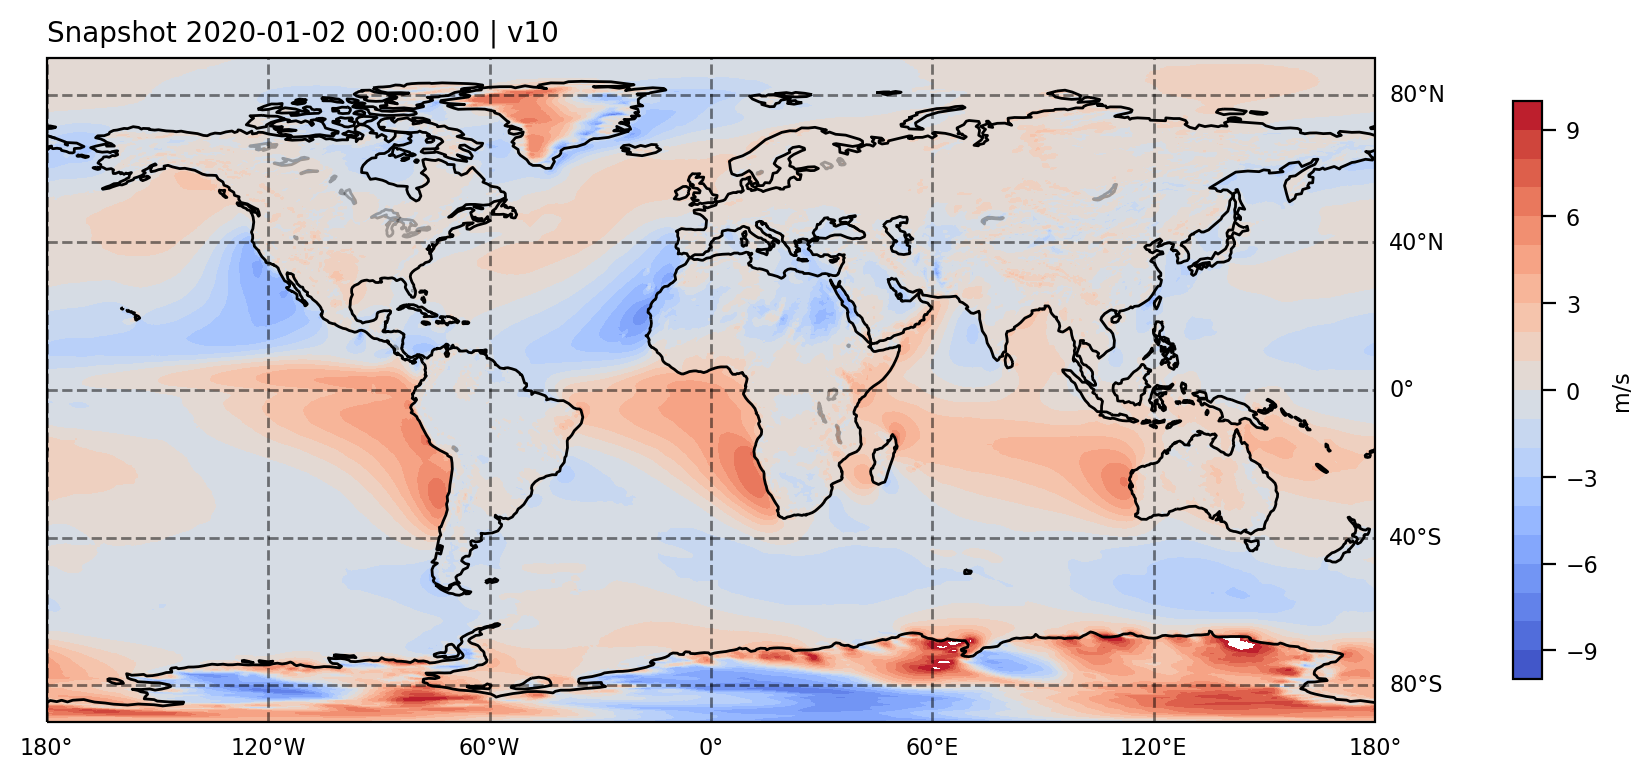

In [30]:
# to remove solution
var = 'v10'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Snapshot '+str(date_sel) +' | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_ANN.longitude, ERA5_ANN.latitude, ERA5_ANN[var],
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()

It's evident that there are strong southward winds in the subtropics of the Northern Hemisphere, indicated by the blue color, and northward winds in the subtropics of the Southern Hemisphere. What additional observations can you make when comparing these two climatologies?

 
The meridional winds seam to be strongest on the western side of the continents. The reasons for that are hard to explain here, but we want to look at their overall effect. For that, we can plot the zonal mean of the zonal and meridional winds:


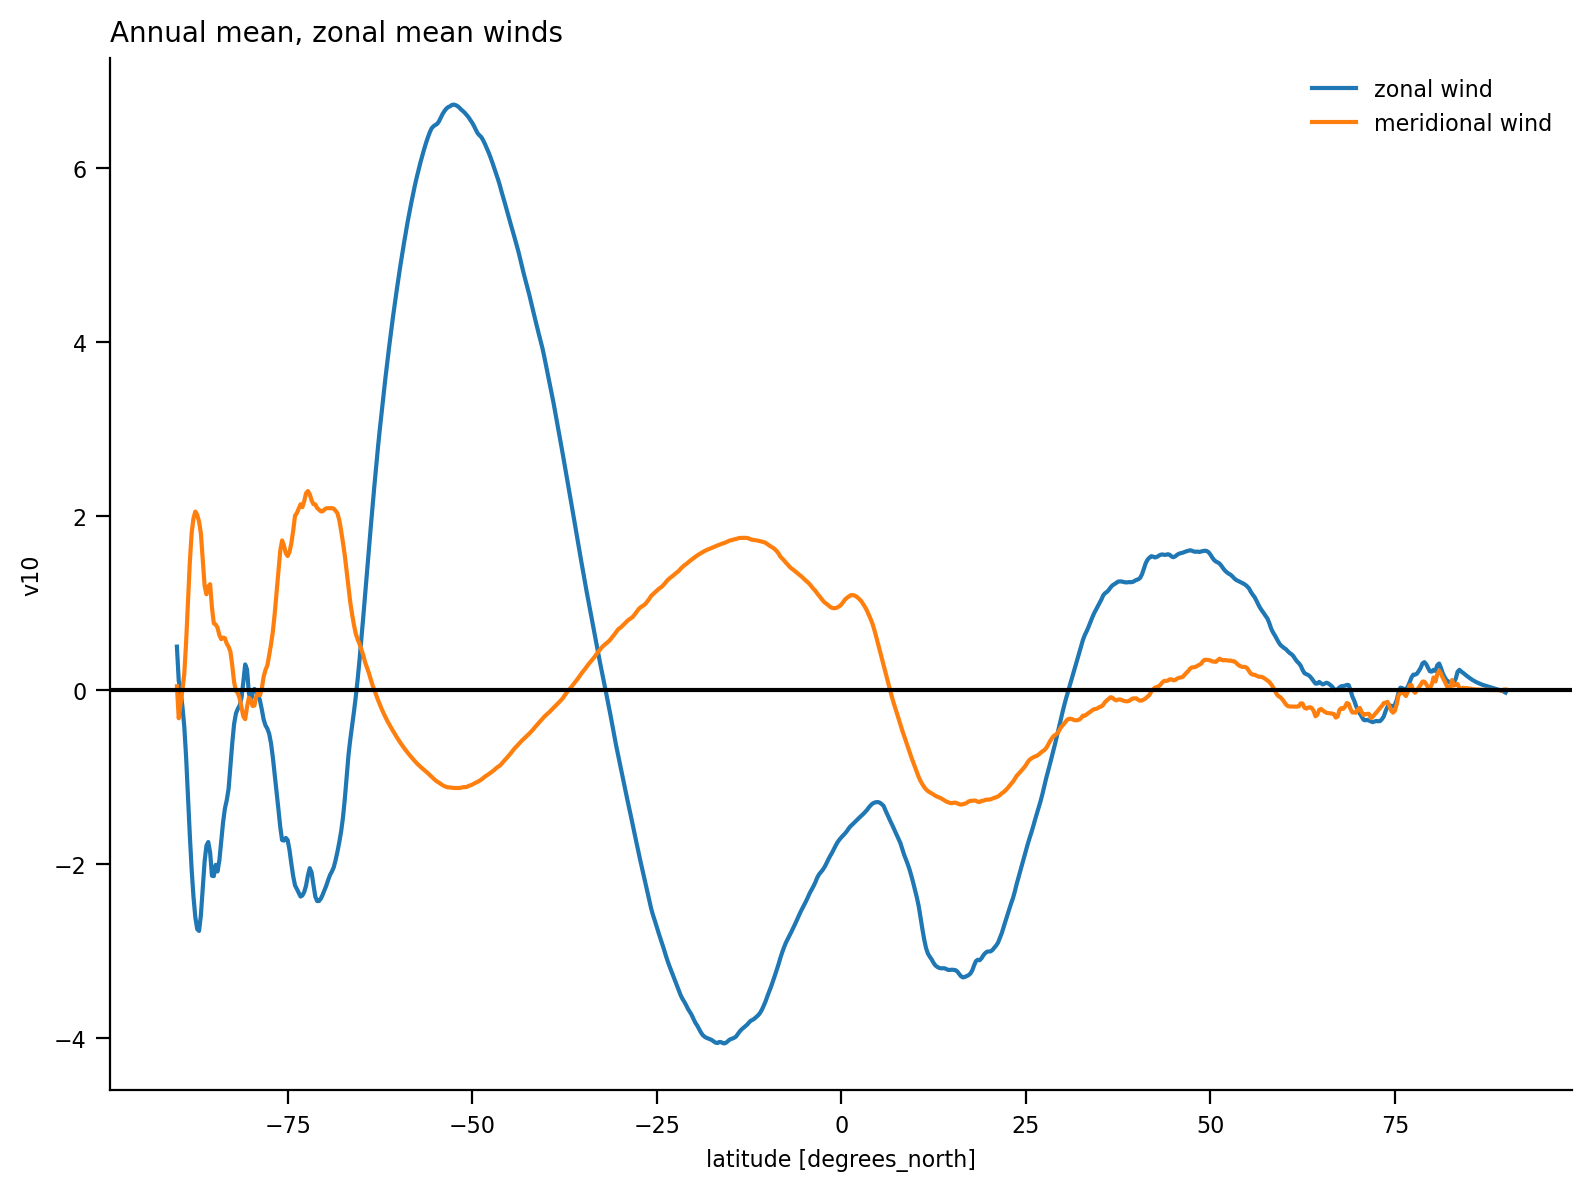

In [31]:
ERA5_ANN.mean('longitude')['u10'].plot(label = 'zonal wind') # find the u10 mean value over the latitude 
ERA5_ANN.mean('longitude')['v10'].plot(label = 'meridional wind') # find the v10 mean value over the latitude 
plt.legend() # add legend
plt.title('Annual mean, zonal mean winds', loc= 'left' ) # add title
ax = plt.gca() 
ax.axhline(0, color = 'black') # add a black line at x=0

### *Discussion Questions:*
- Considering the wind speed figure provided, what factors contribute to the noticeable disparities between the Northern and Southern Hemispheres in terms of wind patterns?

In [32]:
# to_remove explanation

print (""" 
The continents influence the strength of the winds, and since the continents are so unevenly positioned on on the planet, the winds are weaker in the North then in the South. The strongest winds occur in the Southenr Ocean, where we nearly ahve no continents, and the winds must get very strong to create the same amount of drag as over the large land masses in the Northern Hemisphere.
""")


 
The continents influence the strength of the winds, and since the continents are so unevenly positioned on on the planet, the winds are weaker in the North then in the South. The strongest winds occur in the Southenr Ocean, where we nearly ahve no continents, and the winds must get very strong to create the same amount of drag as over the large land masses in the Northern Hemisphere.



# Section 3: Seasonal Climatology

Now, let's examine how the zonal mean winds vary throughout the seasons. We will focus on the zonal component and create a special type of diagram called a Hoffmöller diagram. In this diagram, the horizontal axis represents latitude, while the vertical axis represents time.

By using the Hoffmöller diagram, we can visualize how the average east-west winds change with each season and also observe the differences in seasons over the years. 


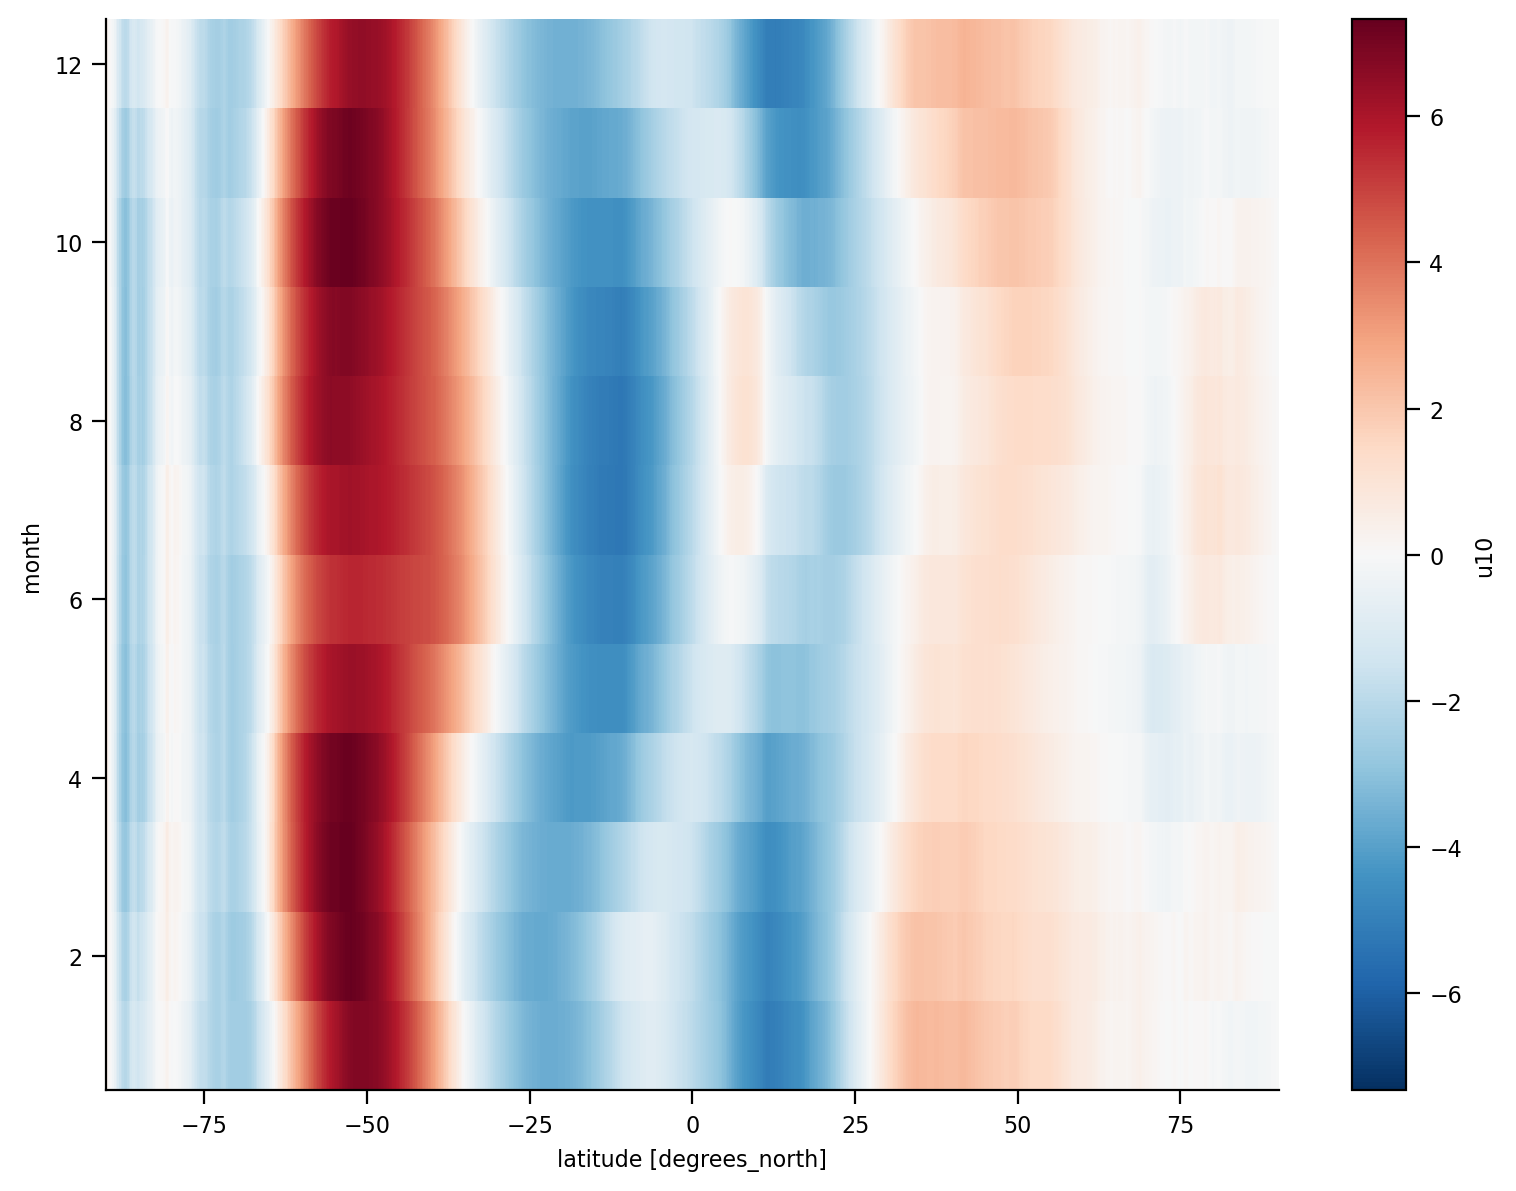

In [33]:
# the groupby command regroups the data by month, such that all Januarys, all Februaries, .. and so on are taken the mean over
# note how we use several commands in one line. python perfom them by order. slice (long, u10), groupby, mean and lastely plot. 
ERA5_mm.mean('longitude')['u10'].groupby('time.month').mean().plot()

### *Exercise*:

Now, let's proceed with analyzing the meridional winds. We will create a similar Hoffmöller diagram, but this time focusing on the meridional component.    

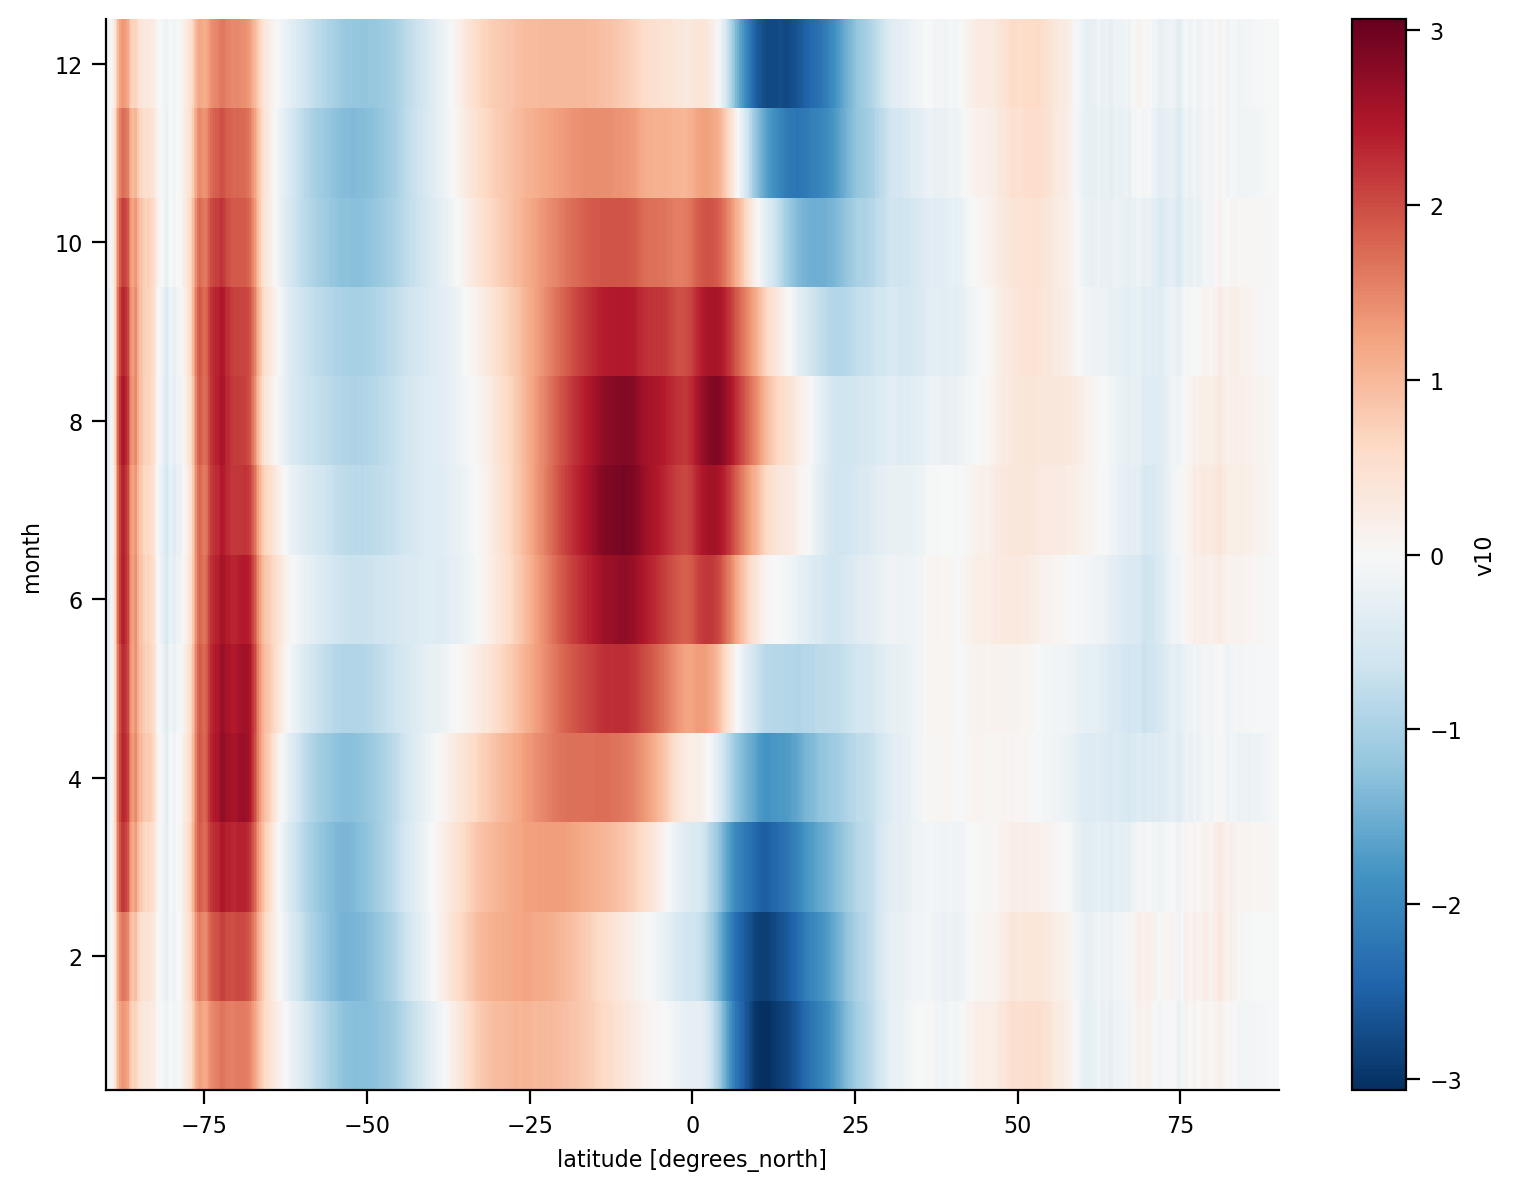

In [34]:
# to remove solution

ERA5_mm.mean('longitude')['v10'].groupby('time.month').mean().plot()

### *A few note:*
- The winds in the Southern Hemisphere appear to be generally stronger compared to the Northern Hemisphere.
- The period between June and September shows strong meridional winds. These winds result from the seasonal variation of the Hadley cell. During the winter hemisphere in each respective hemisphere, the Hadley cell becomes much stronger, leading to the intensification of meridional winds.
- It is evident from the colorbars that the zonal winds are approximately twice as strong as the meridional component. Does that align with the Cell structure shown above?

# Summary

Throughout this tutorial, you have gained a basic understanding of atmospheric circulation by analyzing surface winds using ERA5 reanalysis data. Here are the key points covered:

- You explored the distribution of westerlies and easterlies across the globe, observed their seasonal variations, and recognized that these wind patterns are the result of statistical analysis of many individual storms.
- You observed that the strongest winds were found to occur over the Southern Ocean.

You learned 
- how to create climatologies by aggregating data over different dimensions of the dataset, allowing you to analyze long-term average patterns.
- how to group data by timestamps, specifically by month, to investigate seasonal variations.

### Bonus:

- Plot the global map for DJF and JJA of the zonal wind. What do you see when you compare the mid-latitudes? (you can also plot their difference!)

- Plot trend of the zonal mean zonal wind in DJF


That is because the solar insulation leads to varying circulation patterns with seasons. 
More about this you can find in [Global Physical Climatology](https://www.atmos.washington.edu/~dennis/gpc.html), 
[The Atmospheric General Circulation](https://www.cambridge.org/us/academic/subjects/earth-and-environmental-science/atmospheric-science-and-meteorology/atmospheric-general-circulation?format=HB&isbn=9781108474245)
or the first few chapters of this evolving draft [Physics of Earth's Climate](https://climate-dynamics.org/wp-content/uploads/2017/04/Climate_Book.pdf)


In [36]:
# to remove solution
# note, this codes takes a while to run
ERA5_season = ERA5_mm.groupby('time.season').mean()

var='u10'
season='DJF'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Zonal Wind DJF climatology | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_season.longitude, ERA5_season.latitude, ERA5_season.sel(season=season)[var],
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()


var='u10'
season='JJA'
F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Meridional Wind DJF climatology | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_season.longitude, ERA5_season.latitude, ERA5_season.sel(season=season)[var],
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()

# difference:
var='u10'
pdata =ERA5_season.sel(season='DJF')[var] - ERA5_season.sel(season='JJA')[var]

F, ax = set_projection_figure(projection = ccrs.PlateCarree(), figsize = (9, 5.5) )
ax.set_title('Meridional Wind DJF climatology | '+ var , loc ='left')
dataplot = ax.contourf(ERA5_season.longitude, ERA5_season.latitude,pdata ,
                       levels = colorlevels_clim,
                       transform=ccrs.PlateCarree(), cmap= plt.cm.coolwarm)
plt.colorbar(dataplot, orientation='vertical', label = 'm/s', shrink= 0.55 , pad = 0.08)
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x1278ed510> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x152e55090> (for post_execute):


KeyboardInterrupt: 